#### Import libraries and vectors:

In [116]:
import sqlite3
import random
import pickle
import numpy as np
import nltk.tokenize as tk
import matplotlib.pyplot as plt
import gensim.models as gs
import additional.phrase2vec as p2v

from sklearn import metrics
import sklearn.metrics as met
from sklearn import cross_validation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from sklearn import svm
from sklearn import neighbors
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_regression

from sqlite3 import Error
import warnings
warnings.filterwarnings("ignore")

#### Load vector libraries:

In [117]:
w2v_path = #pass to GoogleNews-vectors-negative300.bin'
w2v = gs.Word2Vec.load_word2vec_format(w2v_path, binary=True)
out_dim = 300  # Dimension of output vectors
p2v_no_emoji = p2v.Phrase2Vec(out_dim, w2v, e2v=None)
sqlite_file = '/Users/sulpak/emotional_DC/db.sqlite3'

#### Classes: 

In [118]:
class Tweet(object):
    def __init__(self, user_id, tweet_id, coordinates, place,
                 text_original, text_clean_with_emojis, text_clean_without_emojis,
                 emoji_types, emoji_cnts
                ):
        
        self.user_id = user_id
        self.tweet_id = tweet_id
        self.coordinates = coordinates
        self.place = place
        
        self.text_original = text_original
        self.text_clean_with_emojis = text_clean_with_emojis
        self.text_clean_without_emojis = text_clean_without_emojis
        
        self.emoji_types = emoji_types
        self.emoji_cnts = emoji_cnts

#### Functions: 

In [119]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [120]:
def select_all_votes(conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM emotions_vote") 
    rows = cur.fetchall()
    return rows

In [121]:
def select_all_tweets(conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM emotions_tweet") 
    rows = cur.fetchall()
    return rows

In [122]:
def get_tweet(tweets, t_id):
    tuples = [item for item in tweets if item[0] == t_id]
    return tuples[0]

def get_text(tweet):
    return tweet[2]

In [123]:
def averaged_results(labeled_tweets, annotators_cnt):
    labeled_tweets_avg = {}
    majority_cnt = round(annotators_cnt/2)+1
    cnt = 0
    for key in labeled_tweets:
        if len(labeled_tweets[key])>=annotators_cnt:
            label_avg = []
            for em_ind in range (0, 8):
                em_cnt = 0
                em_int_sum = 0
                for l in labeled_tweets[key]:
                    if l[em_ind]>0:
                        em_cnt +=1
                        em_int_sum += l[em_ind]
                if em_cnt>0 and em_cnt>=majority_cnt:
                    em_int_avg = em_int_sum/em_cnt
                    label_avg.append(em_int_avg)
                else:
                    label_avg.append(0.0)

            labeled_tweets_avg.update({key: label_avg})
            cnt +=1


    return labeled_tweets_avg    

In [124]:
def one_emotion_tweets(text_and_label):
    tweets_one_emotion = {}

    for key in text_and_label:
        value = text_and_label[key]
        non_zero_cnt = np.count_nonzero(value)
        if non_zero_cnt<2:
            tweets_one_emotion.update({key:text_and_label[key]})

    return tweets_one_emotion

In [125]:
def emoji_in_text(text):
    emoji = ""
    
    for e in emoji_types:
        if e in text:
            emoji = e
    
    return emoji

In [126]:
def read_emoji_types():
    emoji_types = []

    with open("additional/emoji_list.txt") as f:
        for line in f:
            my_array = line.split()
            emoji = my_array[0]
            emoji_types.append(emoji)

    return emoji_types

In [127]:
def prepare_tweet_vector_averages(tweet_with_label, tweets, p2v, include_emoji):
    tokenizer = tk.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

    avg_vecs = list()
    y = list()

    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        inter = set(tokens).intersection(emoji_types)
        emoji_found = list(inter)[0]
        emoji_index = tokens.index(emoji_found)
        
        #exclude the emoji from learning
        if not include_emoji:
            tokens.pop(emoji_index)
        y.append(tweet_with_label[tweet])

        avg_vecs.append(np.sum([p2v[x] for x in tokens], axis=0) / len(tokens))
    
    return avg_vecs, y

In [128]:
def convert_labels_to_int(train_y_float):
    train_y_int = []

    for y in train_y_float:
        int_label = []
        for i in range (0, 8):
            int_part = int(y[i])
            tail_part = y[i] - int(y[i])
            if tail_part>=0.5: int_part+=1
            int_label.append(int_part)
        
        train_y_int.append(int_label)
    
    return train_y_int

In [129]:
def convert_labels_to_binary(train_y_int):
    train_y_binary = []

    for y in train_y_int:
        bin_label = []
        for i in range (0, 8):
            if y[i]>0:
                bin_label.append(1)
            else:
                bin_label.append(0)
        
        train_y_binary.append(bin_label)
    
    return train_y_binary

In [130]:
def convert_labels_to_class(train_y_float):
    train_y_class = []

    for y in train_y_float:
        l = 8
        for i in range (0, 8):
            if y[i]>0:
                l = i
        train_y_class.append(l)    

    return train_y_class

In [131]:
def divide_the_set(texts, y_class, dist, percent_training):
    train_size = int(len(chosen_dict)*percent_training)
    training_dict = {}
    testing_dict = {}
    
    for e in range (0, 9):
        e_dict = {}

        for i in range (0, len(y_class)):
            if y_class[i]==e:
                e_dict.update({texts[i]:y_class[i]})
                
        
        train_size = int(len(e_dict)*percent_training)
        train_keys= random.sample(e_dict.keys(), train_size)
        test_keys = [item for item in e_dict.keys() if item not in train_keys]

        for key in train_keys:
            training_dict.update({key:chosen_dict[key]})
        for key in test_keys:
            testing_dict.update({key:chosen_dict[key]})

    return training_dict, testing_dict

In [132]:
def draw_heatplot(a):
    print("   ag  ds  fr  jy  sd  sr  tr  at")
    column_labels = ['']
    row_labels = list('')

    heatmap = a

    fig, ax = plt.subplots()
    #heatmap = ax.pcolor(heatmap, cmap=plt.cm.Blues)

    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    plt.ylabel('actual emotion')
    plt.xlabel('predicted emotion')
    plt.imshow(heatmap)

    plt.show()

In [133]:
def draw_confusion_matrix(values_pred, values_true):
    h, w = 9, 9
    a = [[0 for x in range(w)] for y in range(h)] 
    
    for i in range (0, len(values_pred)):
        if values_pred[i]==values_true[i]:
            a[values_pred[i]][values_pred[i]] +=1
        else:
             a[values_true[i]][values_pred[i]] +=1
    
    #a = numpy.delete(a,(0,1,2,5,6,7), axis=0)
    #a = numpy.delete(a,(0,1,2,5,6,7), axis=1)
    draw_heatplot(a)
    print()    

In [134]:
def dist_of_emotions(mylist):
    dist = [0]*9

    for t in mylist:
        dist[t] += 1

    return dist

# CLASSIFICATION / REGRESSION functions

In [135]:
def multiclass_classification(train_vectors, train_y_class, test_vectors, test_y_class, cv, clf, clf_name):
    print(clf_name)
    print()

    scores = cross_validation.cross_val_score(clf, train_vectors, train_y_class, cv=cv)
    print("Cross Validation Accuracy on Training Set:\n %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

    clf.fit(train_vectors, train_y_class)
    predictions = clf.predict(test_vectors)
    
    accuracy = met.accuracy_score(test_y_class, predictions)
    f1 = met.f1_score(test_y_class, predictions, average='weighted')

    print('Accuracy on Test Set:\n %0.5f, f1=%0.5f' % (accuracy, f1))
    print()
    draw_confusion_matrix(predictions, test_y_class)

    print()

In [136]:
def multioutput_classification(train_vectors, train_labels, test_vectors, test_labels, clf, clf_name):
    print(clf_name)
    print()
    train_vectors = np.array(train_vectors)
    train_labels = np.array(train_labels)

    test_vectors = np.array(test_vectors)
    test_labels = np.array(test_labels)
    
    multi_target_clf = MultiOutputClassifier(clf, n_jobs=-1)

    cnt = 0
    predictions_label = multi_target_clf.fit(train_vectors, train_labels).predict(test_vectors)
    for i in range (0, len(test_labels)):
        if np.equal(test_labels[i], predictions_label[i]).all():
            cnt += 1
    accuracy = round(cnt/len(test_labels)*100, 2)
    
    try:
        precision_value = round(100*metrics.precision_score(test_labels, predictions_label, average='macro'), 2)
        recall_value = round(100*metrics.recall_score(test_labels, predictions_label, average='micro'), 2)
        f1_value = round(100*metrics.f1_score(test_labels, predictions_label, average='weighted'), 2)
        
        result = "correctly predicted: " + str(accuracy) + " %\nprecision: " + str(precision_value) + "\nrecall: " + str(recall_value) + "\nf1: " + str(f1_value)
    except:
        result = "correctly predicted: " + str(accuracy) + " %"
    
    print(result)
    print()

In [137]:
def regression(train_vectors, train_values, test_vectors, test_values, rgs, rgs_name):
    train_vectors = np.array(train_vectors)
    train_values = np.array(train_values)

    test_vectors = np.array(test_vectors)
    test_values = np.array(test_values)

    prediction = MultiOutputRegressor(rgs).fit(train_vectors, train_values).predict(test_vectors)
    ev_sc = round(explained_variance_score(test_values, prediction),2)#, multioutput='uniform_average')
    r2_sc = round(r2_score(test_values, prediction),2)#, multioutput=[0.3, 0.7])
    mse = round(mean_squared_error(test_values, prediction) , 2) 
    mae = round(mean_absolute_error(test_values, prediction), 2)#, multioutput=[0.3, 0.7])
    cos_sim_list = cosine_similarity(test_values, prediction)
    cos_sim = round(np.mean(cos_sim_list), 2)
    
    print(rgs_name, "\n")
    print("Cosine similarity: ", str(cos_sim))
    print("Explained variance: ", str(ev_sc))
    print("R2 score: ", str(ev_sc))
    print("Mean squared error: ", str(mse))
    print("Median absolute error: ", str(mae))
    print()

#### Read from DB

In [138]:
conn = create_connection(sqlite_file)
votes = select_all_votes(conn)
tweets = select_all_tweets(conn)

In [141]:
def raw_results(tweets, votes):
    labeled_tweets = {}
    cnt = 0
    for v in votes:
        voted_tweet = get_tweet(tweets, v[1])
        text = get_text(voted_tweet)
        label = list(v[3:11])
        user = v[2]
        try:
            labeled_tweets[text].append(label)
        except:
            labeled_tweets.update({text: []})
            labeled_tweets[text].append(label)
    return labeled_tweets

In [146]:
emoji_types = read_emoji_types()
print(len(emoji_types))

text_and_labels = raw_results(tweets, votes)
print(len(text_and_labels))

text_and_averagLabel = averaged_results(text_and_labels, 3)
print(len(text_and_averagLabel))

singleEmotionText_and_averageLabel = one_emotion_tweets(text_and_averagLabel)
print(len(singleEmotionText_and_averageLabel))

41
997
203
176


# Chosing the set

In [147]:
#chosen_dict = singleEmotionText_and_averageLabel
chosen_dict = text_and_averagLabel

#### Divide set to training and testing

In [148]:
texts = list(chosen_dict.keys())
y_float = list(chosen_dict.values())
y_int = convert_labels_to_int(y_float)
y_binary = convert_labels_to_binary(y_int)
y_class = convert_labels_to_class(y_float)

In [149]:
training_dict, testing_dict = divide_the_set(texts, y_class, dist_of_emotions(y_class), 0.8)
print("Train set size: ", len(training_dict))
print("Test set size: ", len(testing_dict))

Train set size:  158
Test set size:  45


#### PROCESS (turn tweets to vectors):

In [150]:
train = training_dict.keys()
train_y = training_dict.values()
test = testing_dict.keys()
test_y = testing_dict.values()

In [151]:
train_vectors, train_y_float = prepare_tweet_vector_averages(text_and_averagLabel, train, p2v_no_emoji, True)
train_y_int = convert_labels_to_int(train_y_float)
train_y_binary = convert_labels_to_binary(train_y_int)
train_y_class = convert_labels_to_class(train_y_float)

test_vectors, test_y_float = prepare_tweet_vector_averages(text_and_averagLabel, test, p2v_no_emoji, True)
test_y_int = convert_labels_to_int(test_y_float)
test_y_binary = convert_labels_to_binary(test_y_int)
test_y_class = convert_labels_to_class(test_y_float)

print("Tweets were converted to vectors")

Tweets were converted to vectors


In [152]:
print("Emotion distributions:\n")
print("Whole set:\t", dist_of_emotions(y_class))
print("Training set:\t", dist_of_emotions(train_y_class))
print("Test set:\t", dist_of_emotions(test_y_class))

Emotion distributions:

Whole set:	 [1, 1, 0, 114, 31, 13, 3, 8, 32]
Training set:	 [0, 0, 0, 91, 24, 10, 2, 6, 25]
Test set:	 [1, 1, 0, 23, 7, 3, 1, 2, 7]


## Multiclass classification

In [153]:
classifiers = {
        'SGD (n_iter=50)': SGDClassifier(n_iter=50),
        'Random Forest (n_estimators=60)': RandomForestClassifier(n_estimators=60),
        'Nearest neighbors': NearestCentroid(),
        'Naive Bayes': GaussianNB(),
        #'MPL':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
}

SGD (n_iter=50)

Cross Validation Accuracy on Training Set:
 0.55 (+/- 0.102)
Accuracy on Test Set:
 0.42222, f1=0.34921

   ag  ds  fr  jy  sd  sr  tr  at


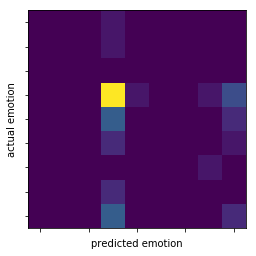



Random Forest (n_estimators=60)

Cross Validation Accuracy on Training Set:
 0.56 (+/- 0.038)
Accuracy on Test Set:
 0.53333, f1=0.38980

   ag  ds  fr  jy  sd  sr  tr  at


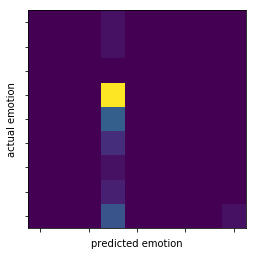



Nearest neighbors

Cross Validation Accuracy on Training Set:
 0.41 (+/- 0.181)
Accuracy on Test Set:
 0.28889, f1=0.30877

   ag  ds  fr  jy  sd  sr  tr  at


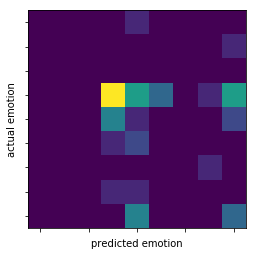



Naive Bayes

Cross Validation Accuracy on Training Set:
 0.53 (+/- 0.226)
Accuracy on Test Set:
 0.42222, f1=0.36040

   ag  ds  fr  jy  sd  sr  tr  at


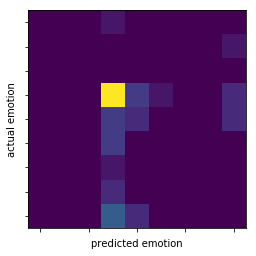

In [154]:
for clf_name in classifiers:
    try:
        multiclass_classification(train_vectors, train_y_class,
                                  test_vectors, test_y_class, 5,
                                  classifiers[clf_name], clf_name)
    except:
        {}

## Multioutput classification (0, 1, 0, 0, 1 ...)

In [155]:
#RF, NB
for clf_name in classifiers:
    try:
        multioutput_classification(train_vectors, train_y_binary,
                                      test_vectors, test_y_binary,
                                      classifiers[clf_name], clf_name)
    except:{}

SGD (n_iter=50)

Random Forest (n_estimators=60)

correctly predicted: 48.89 %
precision: 7.27
recall: 59.52
f1: 44.86

Nearest neighbors

Naive Bayes

correctly predicted: 37.78 %
precision: 10.98
recall: 54.76
f1: 48.99



## Multioutput classification (0, 3, 0, 1, 2 ...)

In [156]:
#RF, NB
for clf_name in classifiers:
    try:
        multioutput_classification(train_vectors, train_y_int,
                                       test_vectors, test_y_int,
                                       classifiers[clf_name], clf_name)
    except:
        {}

SGD (n_iter=50)

Random Forest (n_estimators=60)

correctly predicted: 35.56 %

Nearest neighbors

Naive Bayes

correctly predicted: 28.89 %



In [157]:
regressors = {
    'Support Vector Machine': svm.SVR(),
    'Random Forest': RandomForestClassifier(n_estimators=10),
    'Bayesian Ridge': BayesianRidge(compute_score=True),
    'K-Neighbors': neighbors.KNeighborsRegressor(5),
    'MLP': MLPRegressor(),
    
    #'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
    #'Gradient Boosting': GradientBoostingRegressor(random_state=0)
}

## Multioutput-multiclass regression (0.0, 3.2, 0.0, 1.33, 2.7 ...)

In [158]:
for rgs_name in regressors:
    try:
        regression(train_vectors, train_y_float, test_vectors, test_y_float, regressors[rgs_name], rgs_name)
    except:{}

Support Vector Machine 

Cosine similarity:  0.57
Explained variance:  0.13
R2 score:  0.13
Mean squared error:  0.31
Median absolute error:  0.26

K-Neighbors 

Cosine similarity:  0.54
Explained variance:  -0.0
R2 score:  -0.0
Mean squared error:  0.31
Median absolute error:  0.27

MLP 

Cosine similarity:  0.52
Explained variance:  -0.28
R2 score:  -0.28
Mean squared error:  0.36
Median absolute error:  0.34

